# import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import (
    OrdinalEncoder, OneHotEncoder, PowerTransformer, LabelEncoder
)
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

import category_encoders as ce

import optuna
from scipy import stats
from scipy.stats import norm, skew


import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# get data

In [ ]:
raw_train = pd.read_csv("/content/drive/MyDrive/Airtel_DataScience_Challenge/train.csv")
raw_test = pd.read_csv("/content/drive/MyDrive/Airtel_DataScience_Challenge/test.csv")

In [ ]:
df_train = raw_train.fillna('Standard Class')
target = df_train['profit']

In [ ]:
print(df_train.info())
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6700 entries, 0 to 6699
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               6700 non-null   int64  
 1   departure city   6700 non-null   object 
 2   discount         6700 non-null   float64
 3   price            6700 non-null   float64
 4   no of items      6700 non-null   int64  
 5   location         6700 non-null   object 
 6   class            6700 non-null   object 
 7   segment          6700 non-null   object 
 8   sub-class        6700 non-null   object 
 9   delivery type    6700 non-null   object 
 10  RID              6700 non-null   int64  
 11  profit           6700 non-null   float64
 12  delivery date    6700 non-null   object 
 13  address code     6700 non-null   int64  
 14  departure state  6700 non-null   object 
 15  placement date   6700 non-null   object 
dtypes: float64(3), int64(4), object(9)
memory usage: 837.6+ KB
N

,id,departure city,discount,price,no of items,location,class,segment,sub-class,delivery type,RID,profit,delivery date,address code,departure state,placement date
0,1,Houston,0.2,16.448,2,Central,kariox,Consumer,phone,Standard Class,7981,5.5512,2018-01-01,77095,Texas,2018-01-01
1,2,Westland,0.0,29.700,5,Central,kariox,Consumer,headset,Standard Class,6334,13.3650,2018-01-01,48185,Michigan,2018-01-01
2,3,Westland,0.0,14.730,3,Central,qexty,Consumer,shorts,Standard Class,6333,4.8609,2018-01-01,48185,Michigan,2018-01-01
3,4,Westland,0.0,43.920,3,Central,kariox,Consumer,television,Standard Class,6332,12.7368,2018-01-01,48185,Michigan,2018-01-01
4,5,Westland,0.0,66.580,2,Central,kariox,Consumer,laptop,Standard Class,6331,15.9792,2018-01-01,48185,Michigan,2018-01-01


# eda

In [ ]:
raw_train.loc[raw_train['profit'].between(-2000, 2000)]

,id,departure city,discount,price,no of items,location,class,segment,sub-class,delivery type,RID,profit,delivery date,address code,departure state,placement date
0,1,Houston,0.2,16.448,2,Central,kariox,Consumer,phone,Standard Class,7981,5.5512,2018-01-01,77095,Texas,2018-01-01
1,2,Westland,0.0,29.700,5,Central,kariox,Consumer,headset,Standard Class,6334,13.3650,2018-01-01,48185,Michigan,2018-01-01
2,3,Westland,0.0,14.730,3,Central,qexty,Consumer,shorts,Standard Class,6333,4.8609,2018-01-01,48185,Michigan,2018-01-01
3,4,Westland,0.0,43.920,3,Central,kariox,Consumer,television,Standard Class,6332,12.7368,2018-01-01,48185,Michigan,2018-01-01
4,5,Westland,0.0,66.580,2,Central,kariox,Consumer,laptop,Standard Class,6331,15.9792,2018-01-01,48185,Michigan,2018-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6695,6696,Burlington,0.0,542.940,3,East,kariox,Consumer,battery,Standard Class,9389,152.0232,2021-01-01,5408,Vermont,2021-01-01
6696,6697,San Jose,0.2,276.784,2,West,kariox,Corporate,headset,Standard Class,9597,89.9548,2021-01-01,95123,California,2021-01-01
6697,6698,Burlington,0.0,2.040,1,East,kariox,Consumer,watch,Standard Class,9390,0.9588,2021-01-01,5408,Vermont,2021-01-01
6698,6699,New York City,0.1,207.846,3,East,qexty,Corporate,tshirts,Second Class,440,2.3094,2021-01-01,10024,New York,2021-01-01


In [ ]:
raw_train.loc[raw_train['price'] > 15000]

,id,departure city,discount,price,no of items,location,class,segment,sub-class,delivery type,RID,profit,delivery date,address code,departure state,placement date
150,151,Jacksonville,0.5,22638.48,6,South,fynota,Home Office,sweets,Standard Class,2698,-1811.0784,2018-03-01,32216,Florida,2018-03-01
5895,5896,Lafayette,0.0,17499.95,5,Central,fynota,Corporate,fastfood,Standard Class,6827,8399.9760,2020-10-01,47905,Indiana,2020-10-01


In [ ]:
mask = df_train['class'] == 'kariox'
df_train.loc[mask, 'sub-class'].value_counts()

headset       1025
phone          913
laptop         559
television     513
battery        303
tablet         250
watch          185
lighting       155
charger        131
Name: sub-class, dtype: int64

In [ ]:
mask = df_train['class'] == 'fynota'
df_train.loc[mask, 'sub-class'].value_counts()

colddrinks    597
chocolates    502
sweets         83
fastfood       47
Name: sub-class, dtype: int64

In [ ]:
mask = df_train['class'] == 'qexty'
df_train.loc[mask, 'sub-class'].value_counts()

shorts     641
tshirts    428
hoodies    216
pants      152
Name: sub-class, dtype: int64

In [ ]:
df_train[df_train.duplicated([
        'departure city', 'location', 'class', 'price', 'sub-class', 'delivery type', 'no of items', 'address code', 'departure state']
        )].sort_values(by='departure city')

,id,departure city,discount,price,no of items,location,class,segment,sub-class,delivery type,RID,profit,delivery date,address code,departure state,placement date
360,361,Alexandria,0.0,22.960,7,South,kariox,Corporate,television,Second Class,3277,7.5768,2018-04-01,22304,Virginia,2018-04-01
4332,4333,Chicago,0.2,13.392,3,Central,kariox,Consumer,television,Standard Class,3174,1.5066,2020-03-01,60623,Illinois,2020-03-01
2999,3000,Columbia,0.0,629.950,5,South,fynota,Consumer,colddrinks,Standard Class,6181,176.3860,2019-09-01,29203,South Carolina,2019-09-01
339,340,Columbus,0.3,281.372,2,East,qexty,Home Office,tshirts,Standard Class,3406,-12.0588,2018-04-01,43229,Ohio,2018-04-01
6387,6388,Columbus,0.0,249.950,5,South,fynota,Consumer,chocolates,Standard Class,5251,19.9960,2020-12-01,31907,Georgia,2020-12-01
6559,6560,Detroit,0.0,389.970,3,Central,qexty,Consumer,tshirts,Standard Class,8534,35.0973,2020-12-01,48227,Michigan,2020-12-01
5960,5961,Houston,0.2,10.368,2,Central,kariox,Consumer,phone,Standard Class,1112,3.6288,2020-11-01,77041,Texas,2020-11-01
5841,5842,Houston,0.2,15.552,3,Central,kariox,Corporate,phone,Standard Class,7760,5.4432,2020-10-01,77041,Texas,2020-10-01
3778,3779,Houston,0.2,15.552,3,Central,kariox,Corporate,phone,Standard Class,8379,5.6376,2019-11-01,77095,Texas,2019-11-01
6380,6381,Jackson,0.0,13.900,5,Central,kariox,Home Office,television,Standard Class,4576,3.6140,2020-12-01,49201,Michigan,2020-12-01


In [ ]:
df_train['total_price'] = df_train['price'] * df_train['no of items']
df_train['discount_price'] = df_train['price'] * (1 - df_train['discount'])
df_train['total_disc_price'] = df_train['discount_price'] * df_train['no of items']
# df_train['profit_per_item'] = df_train['profit'] / df_train['no of items']
df_train.sample(5)

,id,departure city,discount,price,no of items,location,class,segment,sub-class,delivery type,RID,profit,delivery date,address code,departure state,placement date,total_price,discount_price,total_disc_price
1019,1020,Springfield,0.2,148.704,6,West,kariox,Consumer,phone,Standard Class,7602,46.4700,2018-09-01,97477,Oregon,2018-09-01,892.224,118.9632,713.7792
386,387,Decatur,0.0,1215.920,8,South,qexty,Corporate,hoodies,Standard Class,5927,316.1392,2018-04-01,35601,Alabama,2018-04-01,9727.360,1215.9200,9727.3600
4131,4132,San Francisco,0.0,305.010,9,West,kariox,Consumer,laptop,First Class,7290,76.2525,2020-01-01,94122,California,2020-01-01,2745.090,305.0100,2745.0900
6524,6525,Newark,0.0,13.400,1,East,qexty,Corporate,shorts,Second Class,9965,6.4320,2020-12-01,19711,Delaware,2020-12-01,13.400,13.4000,13.4000
6498,6499,Springfield,0.0,572.760,6,South,qexty,Consumer,shorts,Second Class,1301,166.1004,2020-12-01,22153,Virginia,2020-12-01,3436.560,572.7600,3436.5600


In [ ]:
df_train.corr()['profit'].sort_values(ascending=False)

profit              1.000000
discount_price      0.621103
total_disc_price    0.563254
price               0.457284
total_price         0.417752
no of items         0.072958
id                  0.016924
RID                 0.008521
address code       -0.040217
discount           -0.220115
Name: profit, dtype: float64

In [ ]:
df_train["profit"] = np.log1p(df_train["profit"])

#Check the new distribution 
sns.distplot(df_train['profit'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_train['profit'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('profit distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df_train['profit'], plot=plt)
plt.show()

In [ ]:
from scipy.special import boxcox1p

In [ ]:
new_target = boxcox1p(target, 0.15)


 mu = 234.46 and sigma = 641.44



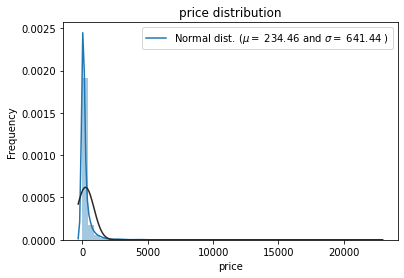

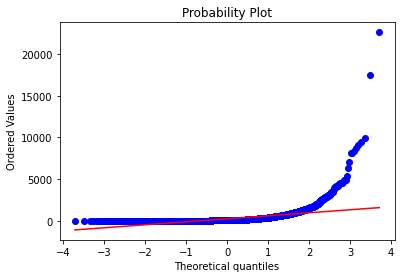

In [ ]:
sns.distplot(df_train['price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_train['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('price distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df_train['price'], plot=plt)
plt.show()

In [ ]:
df_train['profit'].describe()

count    6700.000000
mean       29.121046
std       230.712951
min     -6599.978000
25%         1.713750
50%         8.803200
75%        30.023400
max      8399.976000
Name: profit, dtype: float64

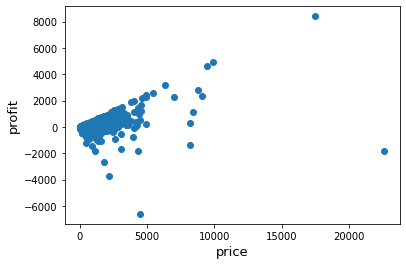

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x = df_train['price'], y = df_train['profit'])
plt.ylabel('profit', fontsize=13)
plt.xlabel('price', fontsize=13)
plt.show()

In [ ]:
mask = df_train['price'] < abs(df_train['profit_per_item'])
df_train.loc[mask]

,id,departure city,discount,price,no of items,location,class,segment,sub-class,delivery type,RID,profit,delivery date,address code,departure state,placement date,total_price,discount_total_price,profit_per_item
475,476,Chicago,0.8,75.600,2,Central,kariox,Consumer,battery,Standard Class,1819,-166.3200,2018-05-01,60623,Illinois,2018-05-01,151.200,60.4800,-83.1600
680,681,Dallas,0.8,1.044,1,Central,kariox,Corporate,headset,Standard Class,8025,-1.8270,2018-07-01,75217,Texas,2018-07-01,1.044,0.8352,-1.8270
717,718,San Antonio,0.8,4.836,2,Central,kariox,Consumer,battery,Standard Class,9780,-12.0900,2018-07-01,78207,Texas,2018-07-01,9.672,3.8688,-6.0450
1092,1093,Mesquite,0.8,0.876,1,Central,kariox,Corporate,headset,Same Day,2107,-1.4016,2018-09-01,75150,Texas,2018-09-01,0.876,0.7008,-1.4016
1203,1204,Chicago,0.8,52.448,2,Central,kariox,Corporate,battery,Standard Class,175,-131.1200,2018-09-01,60623,Illinois,2018-09-01,104.896,41.9584,-65.5600
1248,1249,Chicago,0.8,8.682,1,Central,kariox,Home Office,headset,Second Class,6557,-14.7594,2018-10-01,60653,Illinois,2018-10-01,8.682,6.9456,-14.7594
1382,1383,Huntsville,0.8,0.898,1,Central,kariox,Corporate,headset,Standard Class,7549,-1.5715,2018-10-01,77340,Texas,2018-10-01,0.898,0.7184,-1.5715
1424,1425,Pasadena,0.8,6.928,1,Central,kariox,Consumer,headset,First Class,3394,-11.0848,2018-11-01,77506,Texas,2018-11-01,6.928,5.5424,-11.0848
1713,1714,Houston,0.8,1.234,1,Central,kariox,Consumer,headset,Standard Class,3326,-1.9744,2018-11-01,77095,Texas,2018-11-01,1.234,0.9872,-1.9744
1774,1775,Grand Prairie,0.8,19.432,2,Central,kariox,Consumer,battery,Standard Class,6107,-49.5516,2018-12-01,75051,Texas,2018-12-01,38.864,15.5456,-24.7758


In [ ]:
df_train.skew()

id                   0.000000
discount             1.678510
price               13.798952
no of items          1.306674
RID                  0.009993
profit               7.158362
address code        -0.112956
total_price         14.754270
discount_price      11.854186
total_disc_price    14.181175
profit_per_item      4.035109
dtype: float64

In [ ]:
cont_feat = df_train.select_dtypes(include='float64').columns.tolist()
cont_feat.remove('discount')
cont_feat

['price',
 'profit',
 'total_price',
 'discount_price',
 'total_disc_price',
 'profit_per_item']

In [ ]:
for feat in cont_feat:
    df_train[feat] = stats.yeojohnson(df_train[feat])[0]

In [ ]:
df_train[cont_feat].skew()

price               0.031675
profit              3.228116
total_price         0.010580
discount_price      0.011502
total_disc_price    0.003826
profit_per_item     0.455854
dtype: float64

In [ ]:
train.groupby(['delivery date', 'class']).count()

departure city  ...  placement month cos
delivery date class                   ...                     
2018-01-01    fynota               9  ...                    9
              kariox              44  ...                   44
              qexty               18  ...                   18
2018-02-01    fynota               8  ...                    8
              kariox              33  ...                   33
...                              ...  ...                  ...
2020-12-01    kariox             206  ...                  206
              qexty               86  ...                   86
2021-01-01    fynota              12  ...                   12
              kariox              39  ...                   39
              qexty               13  ...                   13

[111 rows x 15 columns]

In [ ]:
raw_train.head()

,id,departure city,discount,price,no of items,location,class,segment,sub-class,delivery type,RID,profit,delivery date,address code,departure state,placement date
0,1,Houston,0.2,16.448,2,Central,kariox,Consumer,phone,Standard Class,7981,5.5512,2018-01-01,77095,Texas,2018-01-01
1,2,Westland,0.0,29.700,5,Central,kariox,Consumer,headset,Standard Class,6334,13.3650,2018-01-01,48185,Michigan,2018-01-01
2,3,Westland,0.0,14.730,3,Central,qexty,Consumer,shorts,Standard Class,6333,4.8609,2018-01-01,48185,Michigan,2018-01-01
3,4,Westland,0.0,43.920,3,Central,kariox,Consumer,television,Standard Class,6332,12.7368,2018-01-01,48185,Michigan,2018-01-01
4,5,Westland,0.0,66.580,2,Central,kariox,Consumer,laptop,Standard Class,6331,15.9792,2018-01-01,48185,Michigan,2018-01-01


In [ ]:
df_train.loc[df_train['profit'] > 6000]

,id,departure city,discount,price,no of items,location,class,segment,sub-class,delivery type,RID,profit,delivery date,address code,departure state,placement date
5895,5896,Lafayette,0.0,17499.95,5,Central,fynota,Corporate,fastfood,Standard Class,6827,8399.976,2020-10-01,47905,Indiana,2020-10-01


In [ ]:
plot_df = preprocess(df_train)
plot_df.head()

,departure city,discount,price,no of items,location,class,segment,sub-class,delivery type,profit,departure state,placement month,month diff
0,Houston,0.2,16.448,2,Central,kariox,Consumer,phone,Standard Class,5.5512,Texas,1,0
1,Westland,0.0,29.700,5,Central,kariox,Consumer,headset,Standard Class,13.3650,Michigan,1,0
2,Westland,0.0,14.730,3,Central,qexty,Consumer,shorts,Standard Class,4.8609,Michigan,1,0
3,Westland,0.0,43.920,3,Central,kariox,Consumer,television,Standard Class,12.7368,Michigan,1,0
4,Westland,0.0,66.580,2,Central,kariox,Consumer,laptop,Standard Class,15.9792,Michigan,1,0


In [ ]:
plot_df.columns.tolist().remove('profit')


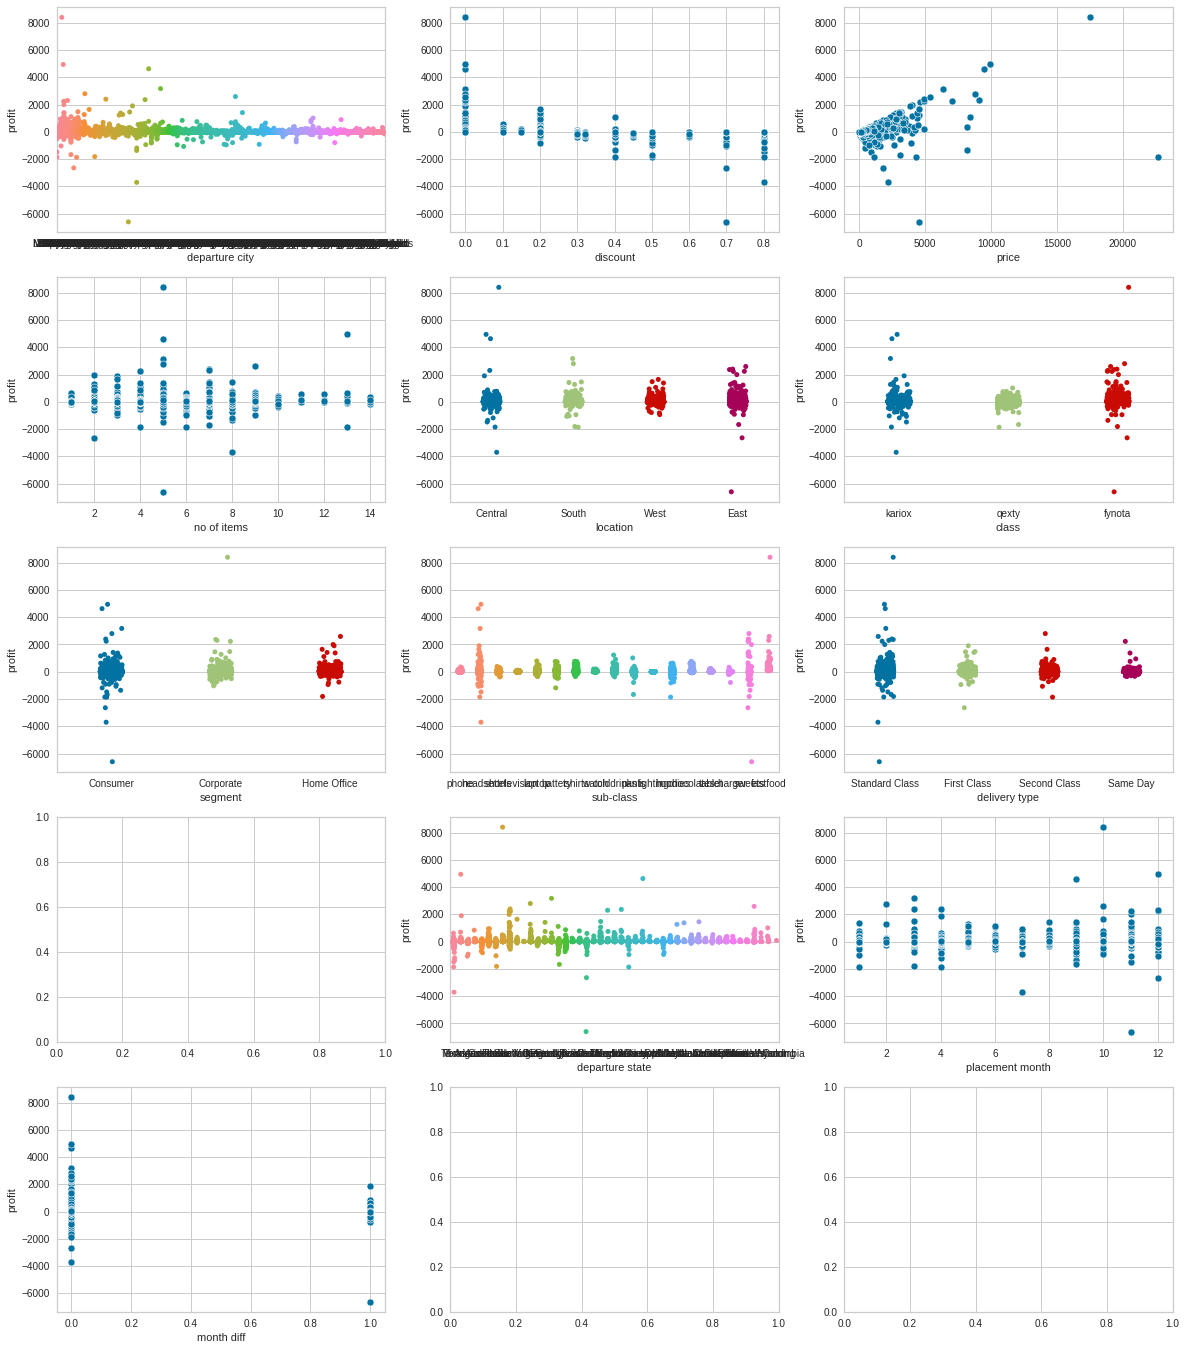

In [ ]:
# sns.scatterplot(data=plot_df, x='month diff', y='profit',)
fig, ax = plt.subplots(5, 3, figsize=(20, 24))

for i, feat in enumerate(plot_df.columns):
    if feat == 'profit':
        continue
    
    x, y = divmod(i, 3)

    if feat in cat_features:
        sns.stripplot(data=plot_df, x=feat, y='profit', ax=ax[x, y])
    else:
        sns.scatterplot(data=plot_df, x=feat, y='profit', ax=ax[x, y])

    # ax[x, y].set_xticks(rotation=30)


plt.show()

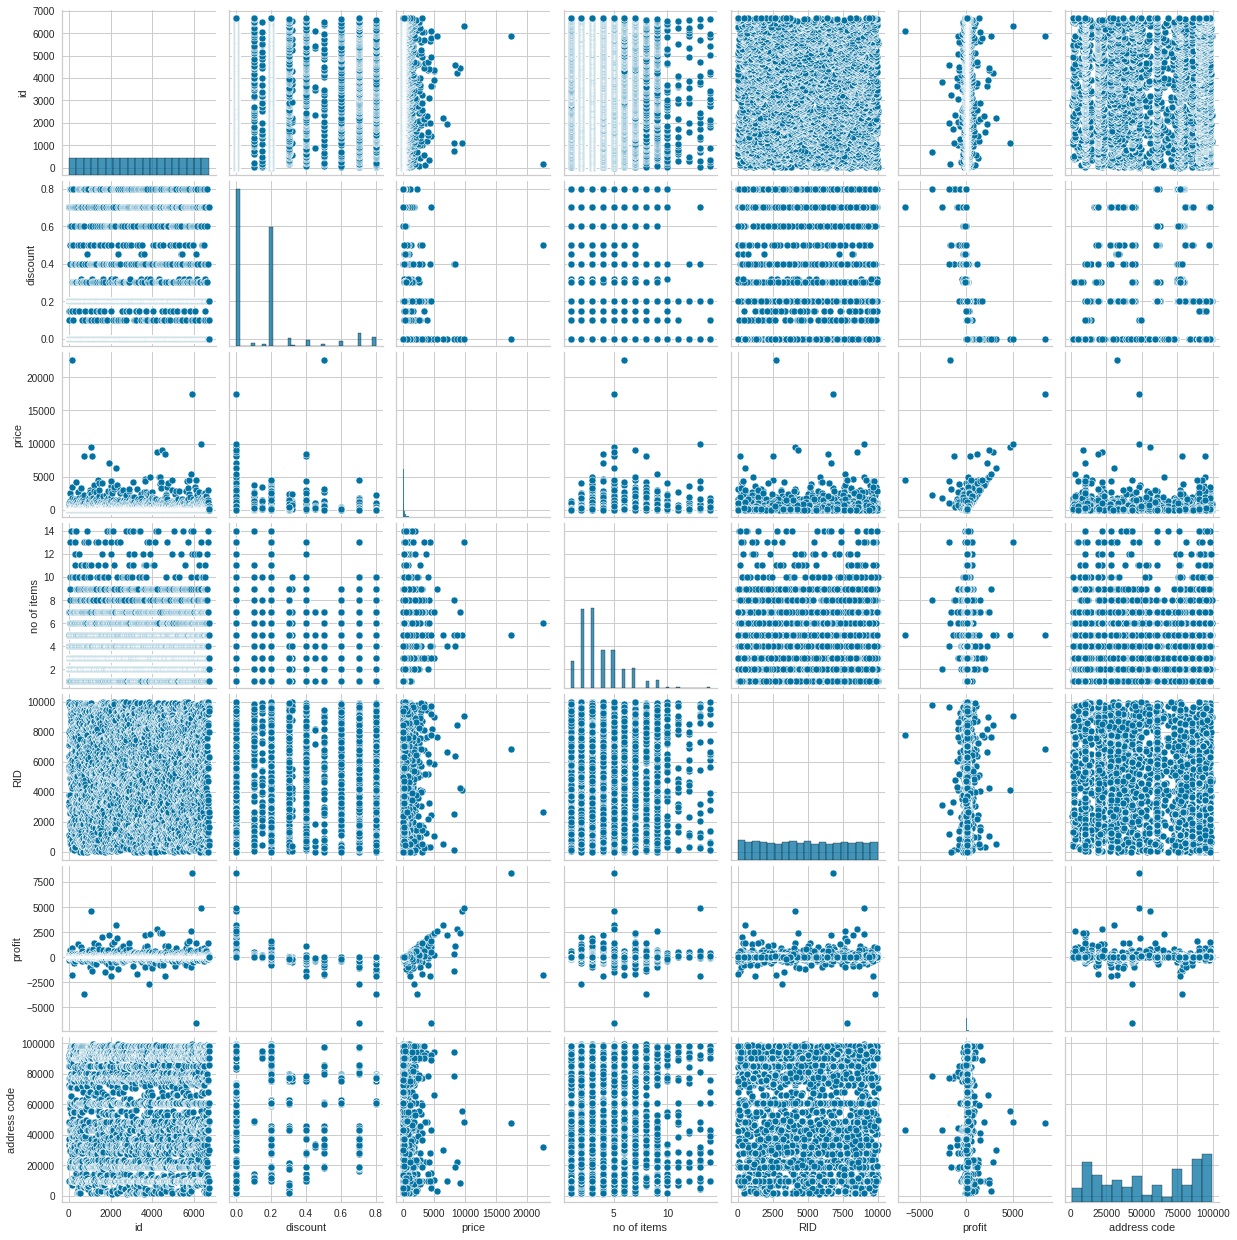

In [ ]:
# plt.figure(figsize=(18, 18))
sns.pairplot(df_train)
plt.show()

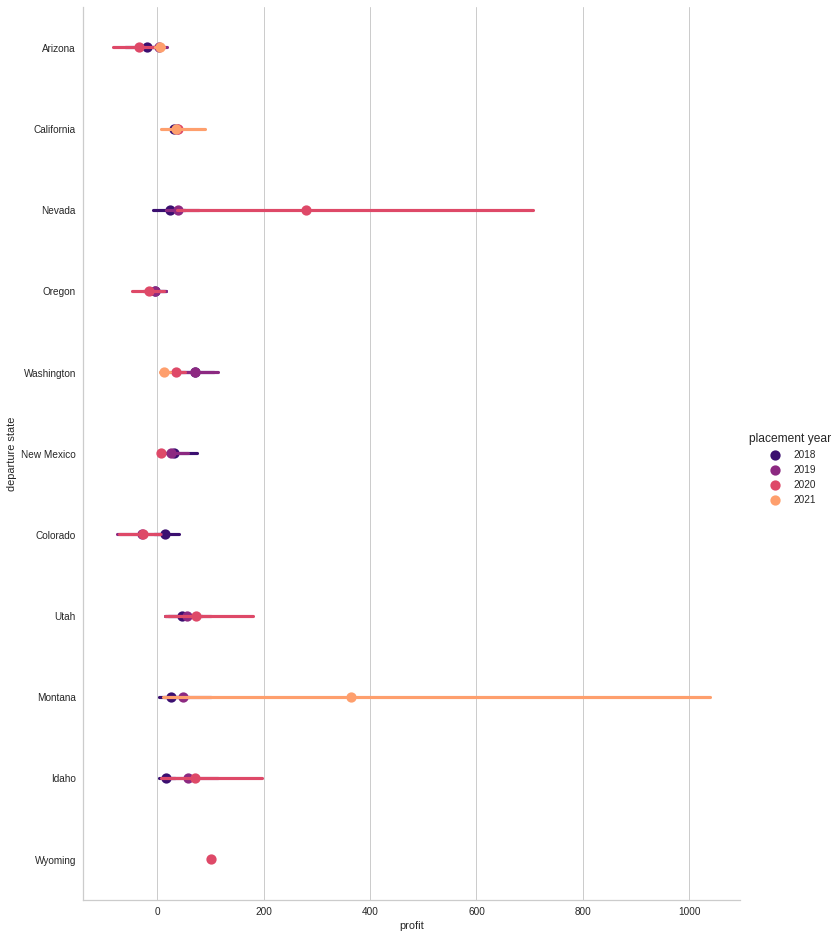

In [ ]:
mask = train['location']=='West'
g = sns.factorplot('profit','departure state',data=train[mask],
                   hue='placement year',
                   size=13,
                   aspect=0.8,
                   palette='magma',
                   join=False,
              )

# preprocess

In [ ]:
def preprocess(dataframe, for_pycaret=False, stage='train'):
    df = dataframe.copy()

    # df = df.loc[df['price'] < 15000]

    df['delivery date'] = pd.to_datetime(df['delivery date'])
    df['placement date'] = pd.to_datetime(df['placement date'])

    # df['placement month'] = df['placement date'].dt.month.astype('str')
    df['placement month'] = df['placement date'].dt.month
    df['delivery month'] = df['delivery date'].dt.month

    # df['placement year'] = df['placement date'].dt.year

    # df['month diff'] = (df['delivery date'] - df['placement date']).dt.days.apply(lambda x: 'Yes' if x > 0 else 'No')
    df['plac_del'] = df['placement month'].astype(str) + df['delivery month'].astype(str)

    # df['placement month sin'] = np.sin(df['placement month'])
    # df['placement month cos'] = np.cos(df['placement month'])

    # df['total_price'] = df['price'] * df['no of items']
    # df['discount_price'] = df['price'] * (1 - df['discount'])
    # df['total_disc_price'] = df['discount_price'] * df['no of items']
    # df['profit_per_item'] = df['profit'] / df['no of items']

    # df['discount_price-2'] = df['discount_price'] ** 2
    # df['discount_price-3'] = df['discount_price'] ** 3
    # df['discount_price-sqrt'] = df['discount_price'] ** 0.5

    # df['total_disc_price-2'] = df['total_disc_price'] ** 2
    # df['total_disc_price-3'] = df['total_disc_price'] ** 3
    # df['total_disc_price-sqrt'] = df['total_disc_price'] ** 0.5

    # df['price-2'] = df['price'] ** 2
    # df['price-3'] = df['price'] ** 3
    # df['price-sqrt'] = df['price'] ** 0.5

    # df['total_price-2'] = df['total_price'] ** 2
    # df['total_price-3'] = df['total_price'] ** 3
    # df['total_price-sqrt'] = df['total_price'] ** 0.5

    if stage == 'train':
        profit_mask = df['profit'].between(-2000, 2000)
        df = df.loc[profit_mask]

    # df = df.drop(['discount', 'no of items'], axis=1)

    skew_feat = df.select_dtypes(include='float64').columns.tolist()

    for feat in skew_feat:
        if feat not in ['profit', 'discount'] and df[feat].skew() > 0.5:
            df[feat] = stats.yeojohnson(df[feat])[0]

    df = df.drop(['delivery date', 'placement date'], axis=1)
    df = df.drop(['delivery month', 'placement month'], axis=1)

    if not for_pycaret:
        ig_cols = ['id', 'RID', 'address code', 'departure city', 'class', 'location']
        df = df.drop(ig_cols, axis=1)
        # df = df.drop(['departure city'], axis=1)

    return df

In [ ]:
train = preprocess(df_train)

In [ ]:
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6696 entries, 0 to 6699
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   discount         6696 non-null   float64
 1   price            6696 non-null   float64
 2   no of items      6696 non-null   int64  
 3   segment          6696 non-null   object 
 4   sub-class        6696 non-null   object 
 5   delivery type    6696 non-null   object 
 6   profit           6696 non-null   float64
 7   departure state  6696 non-null   object 
 8   placement month  6696 non-null   int64  
 9   month diff       6696 non-null   object 
dtypes: float64(3), int64(2), object(5)
memory usage: 575.4+ KB
None


,discount,price,no of items,segment,sub-class,delivery type,profit,departure state,placement month,month diff
0,0.2,2.563190,2,Consumer,phone,Standard Class,5.5512,Texas,1,No
1,0.0,3.005599,5,Consumer,headset,Standard Class,13.3650,Michigan,1,No
2,0.0,2.479895,3,Consumer,shorts,Standard Class,4.8609,Michigan,1,No
3,0.0,3.292826,3,Consumer,television,Standard Class,12.7368,Michigan,1,No
4,0.0,3.591711,2,Consumer,laptop,Standard Class,15.9792,Michigan,1,No


In [ ]:
cont_features = train.select_dtypes(exclude='object').columns.tolist()
cat_features = train.select_dtypes(include='object').columns.tolist()
cat_features

['segment', 'sub-class', 'delivery type', 'departure state', 'month diff']

In [ ]:
le = OrdinalEncoder(dtype='int')
loo = ce.LeaveOneOutEncoder(cols=cat_features)
ohe = OneHotEncoder()

In [ ]:
cat_le = pd.DataFrame(le.fit_transform(train[cat_features], train['profit']), columns=cat_features)
train_le = pd.concat([train[cont_features], cat_le], axis=1)
train_le.head()

,discount,price,no of items,profit,placement month,segment,sub-class,delivery type,departure state,month diff
0,0.2,2.563190,2.0,5.5512,1.0,0.0,10.0,3.0,40.0,0.0
1,0.0,3.005599,5.0,13.3650,1.0,0.0,5.0,3.0,20.0,0.0
2,0.0,2.479895,3.0,4.8609,1.0,0.0,11.0,3.0,20.0,0.0
3,0.0,3.292826,3.0,12.7368,1.0,0.0,14.0,3.0,20.0,0.0
4,0.0,3.591711,2.0,15.9792,1.0,0.0,7.0,3.0,20.0,0.0


In [ ]:
train_loo = loo.fit_transform(train, train['profit'])

In [ ]:
cat_ohe = pd.DataFrame(ohe.fit_transform(train[cat_features]), columns=cat_features)
train_ohe = pd.concat([train[cont_features], cat_ohe], axis=1)
cat_ohe.head()

# sklearn


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer, RobustScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import cross_val_score

In [ ]:
def prepare_data(dataframe, test=False):
    df = dataframe.copy()

    # df = df.loc[df['price'] < 15000]

    df['delivery date'] = pd.to_datetime(df['delivery date'])
    df['placement date'] = pd.to_datetime(df['placement date'])

    # df['placement month'] = df['placement date'].dt.month.astype('str')
    df['placement month'] = df['placement date'].dt.month
    df['delivery month'] = df['delivery date'].dt.month

    # df['placement year'] = df['placement date'].dt.year

    # df['month diff'] = (df['delivery date'] - df['placement date']).dt.days.apply(lambda x: 1 if x > 0 else 0)

    if not test:
        profit_mask = df['profit'].between(-2000, 2000)
        df = df.loc[profit_mask]

    skew_feat = df.select_dtypes(include='float64').columns.tolist()

    for feat in skew_feat:
        if feat not in ['profit', 'discount'] and df[feat].skew() > 0.5:
            df[feat] = stats.yeojohnson(df[feat])[0]

    df['plac_del'] = df['placement month'].astype(str) + df['delivery month'].astype(str)

    df['delivery type'] = df['delivery type'].map({
        'Standard Class': 0,
        'Second Class': 1,
        'Same Day': 2,
        'First Class': 3,
    })

    df['segment'] = df['segment'].map({
        'Consumer': 0,
        'Corporate': 1,
        'Home Office': 2,
    })


    df = df.drop(['delivery date', 'placement date'], axis=1)
    df = df.drop(['delivery month', 'placement month'], axis=1)

    ig_cols = ['id', 'RID', 'address code', 'departure city', 'class', 'location']
    df = df.drop(ig_cols, axis=1)

    df = pd.get_dummies(df)

    return df

In [ ]:
pre_data = prepare_data(df_train)
pre_data.head()

,discount,price,no of items,segment,delivery type,profit,sub-class_battery,sub-class_charger,sub-class_chocolates,sub-class_colddrinks,sub-class_fastfood,sub-class_headset,sub-class_hoodies,sub-class_laptop,sub-class_lighting,sub-class_pants,sub-class_phone,sub-class_shorts,sub-class_sweets,sub-class_tablet,sub-class_television,sub-class_tshirts,sub-class_watch,departure state_Alabama,departure state_Arizona,departure state_Arkansas,departure state_California,departure state_Colorado,departure state_Connecticut,departure state_Delaware,departure state_District of Columbia,departure state_Florida,departure state_Georgia,departure state_Idaho,departure state_Illinois,departure state_Indiana,departure state_Iowa,departure state_Kansas,departure state_Kentucky,departure state_Louisiana,...,departure state_North Carolina,departure state_Ohio,departure state_Oklahoma,departure state_Oregon,departure state_Pennsylvania,departure state_Rhode Island,departure state_South Carolina,departure state_South Dakota,departure state_Tennessee,departure state_Texas,departure state_Utah,departure state_Vermont,departure state_Virginia,departure state_Washington,departure state_Wisconsin,departure state_Wyoming,plac_del_1010,plac_del_1011,plac_del_11,plac_del_1111,plac_del_1112,plac_del_12,plac_del_121,plac_del_1212,plac_del_22,plac_del_23,plac_del_33,plac_del_34,plac_del_44,plac_del_45,plac_del_55,plac_del_56,plac_del_66,plac_del_67,plac_del_77,plac_del_78,plac_del_88,plac_del_89,plac_del_910,plac_del_99
0,0.2,2.574307,2,0,0,5.5512,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.0,3.021102,5,0,0,13.3650,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.0,2.490275,3,0,0,4.8609,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.0,3.311608,3,0,0,12.7368,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.0,3.614280,2,0,0,15.9792,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
pre_data.groupby('segment').mean()

,discount,price,no of items,profit,placement month,delivery month
segment,,,,,,
Consumer,0.157652,3.514484,3.750996,23.203950,7.834946,7.789414
Corporate,0.158547,3.497082,3.841487,24.461948,7.862035,7.682975
Home Office,0.145488,3.493730,3.839539,34.068091,7.715426,7.680851


In [ ]:
pre_test = prepare_data(raw_test, test=True)
pre_test.head()

,discount,price,no of items,segment,sub-class,delivery type,departure state,placement month,month diff
0,0.0,2.835460,5,Consumer,television,Standard Class,California,1,0
1,0.2,4.671399,3,Consumer,colddrinks,Standard Class,California,1,0
2,0.0,1.419001,2,Consumer,television,Standard Class,Connecticut,1,0
3,0.2,2.282789,5,Consumer,tablet,First Class,Illinois,1,0
4,0.0,4.425598,3,Home Office,laptop,Standard Class,Washington,1,0


In [ ]:
cont_features = train.select_dtypes(exclude='object').columns.tolist()
cat_features = train.select_dtypes(include='object').columns.tolist()
print(cat_features, cont_features)

['segment', 'sub-class', 'delivery type', 'departure state', 'month diff'] ['discount', 'price', 'no of items', 'profit', 'placement month']


In [ ]:
col_transformer = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), ['price']),
        ('zo', OrdinalEncoder(), ['segment', 'delivery type', 'month diff']),
        ('ohe', OneHotEncoder(handle_unknown='ignore'), ['departure state', 'sub-class'])
    ],
    remainder='passthrough',
)

In [ ]:
regressor = GradientBoostingRegressor(
    n_estimators=261,
    max_depth=7,
    learning_rate=0.065
)
# regressor = DecisionTreeRegressor(max_depth=4)
model = TransformedTargetRegressor(regressor=regressor, transformer=QuantileTransformer(output_distribution='normal'))

In [ ]:
full_pipe = Pipeline(steps=[
        ('preprocess', col_transformer),
        ('model', regressor),
])

In [ ]:
X = pre_data.drop('profit', axis=1)
y = pre_data['profit']
print(X.shape)

(6686, 9)


In [ ]:
scores = cross_val_score(full_pipe, X, y, cv=5, scoring='r2', n_jobs=-1,)
print(scores)
print(f'Mean R2 Score: {scores.mean() * 100:.4f}')

[0.41069009 0.76409302 0.81706197 0.31262043 0.88434845]
Mean R2 Score: 63.7763


In [ ]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split

def lgbm_objective(trial):

    param = {
        'num_iterations': 1000,
        'n_estimators': trial.suggest_int('n_estimators', 34000, 40000),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.1, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 0.1),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.7, 0.8, 0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.6,0.7,0.8,1.0]),
        'learning_rate': 0.1,
        # 'learning_rate': trial.suggest_categorical('learning_rate', [0.006, 0.008, 0.01, 0.014, 0.017, 0.02, 0.1, 0.5]),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'num_leaves' : trial.suggest_int('num_leaves', 400, 500),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 50),
    }

    regressor_obj = lgb.LGBMRegressor(**param)

    model = TransformedTargetRegressor(
        regressor=regressor_obj, 
        transformer=QuantileTransformer(output_distribution='normal')
    )
    classifier = Pipeline(steps=[
                    ('preprocess', col_transformer),
                    ('model', model),
    ])

    scores = cross_val_score(classifier, X, y, cv=5, scoring='r2', n_jobs=-1,)
    return scores.mean()
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    # classifier.fit(X_train, y_train)
    
    # y_preds = classifier.predict(X_test)
    # error = r2_score(y_test, y_preds)
    # return error

lgbm_study = optuna.create_study(direction='maximize')  # Create a new study.
lgbm_study.optimize(lgbm_objective, n_trials=50) 

[I 2021-03-20 21:30:33,625] A new study created in memory with name: no-name-ff718a52-4786-4fb6-9c09-e1b77aabfabf
[I 2021-03-20 21:30:36,059] Trial 0 finished with value: 0.6494481266585481 and parameters: {'n_estimators': 39245, 'reg_alpha': 2.4950608782657775, 'reg_lambda': 0.002579391067431726, 'colsample_bytree': 0.8, 'subsample': 0.8, 'max_depth': 7, 'num_leaves': 454, 'min_child_samples': 36}. Best is trial 0 with value: 0.6494481266585481.
[I 2021-03-20 21:30:37,309] Trial 1 finished with value: 0.6353777764243859 and parameters: {'n_estimators': 35713, 'reg_alpha': 6.748284995779513, 'reg_lambda': 0.0031308205729745652, 'colsample_bytree': 0.7, 'subsample': 0.8, 'max_depth': 7, 'num_leaves': 413, 'min_child_samples': 18}. Best is trial 0 with value: 0.6494481266585481.
[I 2021-03-20 21:30:38,830] Trial 2 finished with value: 0.6986132341780589 and parameters: {'n_estimators': 38319, 'reg_alpha': 2.268484171004585, 'reg_lambda': 0.09026228773986898, 'colsample_bytree': 1.0, 'sub

In [ ]:
regressor_obj = lgb.LGBMRegressor(**lgbm_study.best_params)

model = TransformedTargetRegressor(
    regressor=regressor_obj, 
    transformer=QuantileTransformer(output_distribution='normal')
)

classifier = Pipeline(steps=[
                ('preprocess', col_transformer),
                ('model', model),
])

In [ ]:
scores = cross_val_score(classifier, X, y, cv=5, scoring='r2', n_jobs=-1,)
print(scores)
print(f'Mean R2 Score: {scores.mean() * 100:.4f}')

[0.88463247 0.81071816 0.8123944  0.73489103 0.8604421 ]
Mean R2 Score: 82.0616


In [ ]:
lgbm_study.best_params

{'colsample_bytree': 0.8,
 'max_depth': 6,
 'min_child_samples': 24,
 'n_estimators': 35008,
 'num_leaves': 436,
 'reg_alpha': 0.16706327832126452,
 'reg_lambda': 0.012370923954519164,
 'subsample': 0.8}

In [ ]:
classifier.fit(X, y)

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  RobustScaler(copy=True,
                                                               quantile_range=(25.0,
                                                                               75.0),
                                                               with_centering=True,
                                                               with_scaling=True),
                                                  ['price']),
                                                 ('zo',
                                                  OrdinalEncoder(categories='auto',
                                                                 dtype=<class 'numpy.

In [ ]:
preds = classifier.predict(pre_test)
preds

array([ 7.57906513, 31.01210642,  1.0268066 , ...,  7.4288221 ,
        4.56860898,  0.5617141 ])

In [ ]:
final_preds = pd.DataFrame({"id": raw_test['id'], "profit": preds})
final_preds

,id,profit
0,6701,7.579065
1,6702,31.012106
2,6703,1.026807
3,6704,3.920287
4,6705,10.347655
...,...,...
3289,9990,5.235660
3290,9991,8.681160
3291,9992,7.428822
3292,9993,4.568609


In [ ]:
final_preds.to_csv('lgbm_cv_82.csv', index=False)

# catboost

In [ ]:
import catboost as cat
from catboost import Pool, cv

In [ ]:
data = preprocess(df_train)
data.head()

,discount,price,no of items,segment,sub-class,delivery type,profit,departure state,placement month,month diff
0,0.2,2.563190,2,Consumer,phone,Standard Class,5.5512,Texas,1,No
1,0.0,3.005599,5,Consumer,headset,Standard Class,13.3650,Michigan,1,No
2,0.0,2.479895,3,Consumer,shorts,Standard Class,4.8609,Michigan,1,No
3,0.0,3.292826,3,Consumer,television,Standard Class,12.7368,Michigan,1,No
4,0.0,3.591711,2,Consumer,laptop,Standard Class,15.9792,Michigan,1,No


In [ ]:
pt = PowerTransformer()

In [ ]:
cat_X = data.drop('profit', axis=1).reset_index(drop=True)
cat_y = data[['profit']].reset_index(drop=True)

In [ ]:
cat_y = pt.fit_transform(cat_y[['profit']]).reshape(-1)
cat_y

array([-0.1226198 , -0.07717643, -0.12664294, ..., -0.14943388,
       -0.14153334, -0.09644674])

In [ ]:
cat_X.head()

,discount,price,no of items,segment,sub-class,delivery type,departure state,placement month,month diff
0,0.2,2.563190,2,Consumer,phone,Standard Class,Texas,1,No
1,0.0,3.005599,5,Consumer,headset,Standard Class,Michigan,1,No
2,0.0,2.479895,3,Consumer,shorts,Standard Class,Michigan,1,No
3,0.0,3.292826,3,Consumer,television,Standard Class,Michigan,1,No
4,0.0,3.591711,2,Consumer,laptop,Standard Class,Michigan,1,No


In [ ]:
cat_features = cat_X.select_dtypes(include='object').columns.tolist() + ['placement month']
cat_features

['segment',
 'sub-class',
 'delivery type',
 'departure state',
 'month diff',
 'placement month']

In [ ]:
cv_dataset = Pool(
    data=cat_X,
    label=cat_y,
    cat_features=cat_features,
)

In [ ]:
params = {
    "iterations": 1500,
    "learning_rate": 0.052,
    "depth": 7,
    "loss_function": "RMSE",
    'eval_metric': 'R2',
    "verbose":  True,
    'random_seed': 2021,
    "early_stopping_rounds": 100,
}

In [ ]:
scores = cv(
    cv_dataset,
    params,
    fold_count=5,
    plot=True,
)

In [ ]:
folds = KFold(n_splits=5, shuffle=True, random_state=2021)

scores = []
for fold, (train_index, valid_index) in enumerate(folds.split(cat_X, cat_y)):
    
    X_train, X_valid = cat_X.iloc[train_index], cat_X.iloc[valid_index]
    y_train, y_valid = cat_y[train_index], cat_y[valid_index]
    
    train_data = Pool(data=X_train, label=y_train, cat_features=cat_features)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_features)
    
    model = cat.CatBoostRegressor(**params)
    model.fit(
        train_data,
        eval_set=valid_data, 
        use_best_model=True,
        early_stopping_rounds=150,
    )
    
    score = model.get_best_score()['validation']['R2']
    scores.append(score)

print(f'CV mean: {np.mean(scores):.4f}, CV std: {np.std(scores):.4f}')

0:	learn: 0.0548159	test: 0.0542346	best: 0.0542346 (0)	total: 13.6ms	remaining: 20.4s
500:	learn: 0.9712092	test: 0.6925661	best: 0.6926529 (494)	total: 5.82s	remaining: 11.6s
1000:	learn: 0.9836506	test: 0.7023779	best: 0.7027568 (969)	total: 11.8s	remaining: 5.88s
1499:	learn: 0.9902268	test: 0.7067769	best: 0.7073726 (1352)	total: 17.8s	remaining: 0us

bestTest = 0.7073725863
bestIteration = 1352

Shrink model to first 1353 iterations.
0:	learn: 0.0417990	test: 0.0469316	best: 0.0469316 (0)	total: 13.2ms	remaining: 19.8s
500:	learn: 0.9714942	test: 0.8722284	best: 0.8724106 (480)	total: 5.7s	remaining: 11.4s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.8732360737
bestIteration = 634

Shrink model to first 635 iterations.
0:	learn: 0.0508033	test: 0.0257106	best: 0.0257106 (0)	total: 10.3ms	remaining: 15.4s
500:	learn: 0.9648989	test: 0.5695581	best: 0.5695581 (500)	total: 5.58s	remaining: 11.1s
1000:	learn: 0.9821157	test: 0.5807485	best: 0.5807485 (1000)	to

In [ ]:
params = {
    "loss_function": "RMSE",
    'eval_metric': 'R2',
    'random_seed': 2021,
    "verbose": False,
    "iterations": 1500,
    "bootstrap_type": "MVS",
    'one_hot_max_size': 10,

    'bagging_temperature': 0.41392326535418544,
    'colsample_bylevel': 0.09560715082157391,
    'depth': 4,
    'l2_leaf_reg': 2,
    'learning_rate': 0.4269237135928238,
    'random_strength': 19,
    'subsample': 0.35135010935423067
}

In [ ]:
catboost_model = cat.CatBoostRegressor(**params)

In [ ]:
catboost_model.fit(
    cat_X,
    cat_y,
    cat_features=cat_features,
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
test_data = Pool(
    data=preprocess(raw_test, stage='test'),
    cat_features=cat_features,
)

In [ ]:
preds = catboost_model.predict(test_data)
preds

array([-0.08419999, -0.01952301, -0.14508123, ...,  0.05280603,
       -0.18764181, -0.18557424])

In [ ]:
inv_preds = pt.inverse_transform(preds.reshape(-1, 1)).reshape(-1)
inv_preds

array([12.15579366, 23.30476339,  1.70252165, ..., 35.7991927 ,
       -5.5192462 , -5.16998516])

In [ ]:
final_preds = pd.DataFrame({"id": raw_test['id'], "profit": inv_preds})
final_preds

,id,profit
0,6701,12.155794
1,6702,23.304763
2,6703,1.702522
3,6704,19.615321
4,6705,26.231992
...,...,...
3289,9990,0.568445
3290,9991,17.479125
3291,9992,35.799193
3292,9993,-5.519246


In [ ]:
final_preds.describe()

,id,profit
count,3294.00000,3294.000000
mean,8347.50000,23.836246
std,951.04022,158.909474
min,6701.00000,-2687.519970
25%,7524.25000,-0.803170
50%,8347.50000,12.386408
75%,9170.75000,32.574969
max,9994.00000,2563.177709


In [ ]:
final_preds.describe()

,id,profit
count,3294.00000,3294.000000
mean,8347.50000,24.880213
std,951.04022,152.301979
min,6701.00000,-2067.927664
25%,7524.25000,-1.638759
50%,8347.50000,9.744298
75%,9170.75000,31.647476
max,9994.00000,2497.856575


In [ ]:
final_preds.to_csv('catboost_77.csv', index=False)

# lightgbm

In [ ]:
import lightgbm as lgb

In [ ]:
data = preprocess(df_train)
data = data.replace({'No': 0, 'Yes': 1})
data['placement month'] = data['placement month'].astype('category')
data.head()

,discount,price,no of items,segment,sub-class,delivery type,profit,departure state,placement month,month diff
0,0.2,2.574307,2,Consumer,phone,Standard Class,5.5512,Texas,1,0
1,0.0,3.021102,5,Consumer,headset,Standard Class,13.3650,Michigan,1,0
2,0.0,2.490275,3,Consumer,shorts,Standard Class,4.8609,Michigan,1,0
3,0.0,3.311608,3,Consumer,television,Standard Class,12.7368,Michigan,1,0
4,0.0,3.614280,2,Consumer,laptop,Standard Class,15.9792,Michigan,1,0


In [ ]:
lgb_X = data.drop('profit', axis=1)
lgb_y = data['profit'].values

In [ ]:
lgb_X.head()

,discount,price,no of items,segment,sub-class,delivery type,departure state,placement month,month diff
0,0.2,2.574307,2,Consumer,phone,Standard Class,Texas,1,0
1,0.0,3.021102,5,Consumer,headset,Standard Class,Michigan,1,0
2,0.0,2.490275,3,Consumer,shorts,Standard Class,Michigan,1,0
3,0.0,3.311608,3,Consumer,television,Standard Class,Michigan,1,0
4,0.0,3.614280,2,Consumer,laptop,Standard Class,Michigan,1,0


In [ ]:
lgb_X = pd.get_dummies(lgb_X)

In [ ]:
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=int)

In [ ]:
lgb_X[['segment', 'sub-class', 'delivery type', 'departure state', 'placement month', 'month diff']] = oe.fit_transform(
    lgb_X[['segment', 'sub-class', 'delivery type', 'departure state', 'placement month', 'month diff']]
)

In [ ]:
lgb_X.head()

,discount,price,no of items,segment,sub-class,delivery type,departure state,placement month,month diff
0,0.2,2.574307,2,0,10,3,40,0,0
1,0.0,3.021102,5,0,5,3,20,0,0
2,0.0,2.490275,3,0,11,3,20,0,0
3,0.0,3.311608,3,0,14,3,20,0,0
4,0.0,3.614280,2,0,7,3,20,0,0


In [ ]:
cat_features = ['segment', 'sub-class', 'delivery type', 'departure state', 'placement month']

In [ ]:
pt = PowerTransformer()
lgb_y = pt.fit_transform(lgb_y.reshape(-1, 1)).reshape(-1)
lgb_y

array([-0.14787686, -0.09084986, -0.15290889, ..., -0.18131966,
       -0.1714945 , -0.11506688])

In [ ]:
params = {
    # 'cat_feature': cat_features,
    'random_state': 2021,
    'cat_l2': 25.999876242730252,
    'cat_smooth': 89.2699690675538,
    'colsample_bytree': 0.2557260109926193,
    'early_stopping_round': 100,
    'learning_rate': 0.00918685483594994,
    'max_bin': 788,
    'max_depth': 81,
    'metric': "l2",
    'min_child_samples': 292,
    'min_data_per_group': 177,
    'n_estimators': 30000,
    'n_jobs': -1,
    'num_leaves': 171,
    'reg_alpha': 0.7115353581785044,
    'reg_lambda': 5.658115293998945,
    'subsample': 0.9262904583735796,
    'subsample_freq': 1,
    'verbose': -1,
}

lgb_model = lgb.LGBMRegressor(**params)

In [ ]:
k_fold = KFold(n_splits=5, random_state=2021, shuffle=True)

for fold, (train_index, valid_index) in enumerate(k_fold.split(lgb_X, lgb_y)):
    print(f"--> Fold {fold + 1}")
    
    lgb_x_train, lgb_x_valid = lgb_X.iloc[train_index], lgb_X.iloc[valid_index]
    y_train, y_valid = lgb_y[train_index], lgb_y[valid_index]

    lgb_model.fit(
        lgb_x_train,
        y_train,
        eval_set=[(lgb_x_valid, y_valid)], 
        verbose=0,
    )

    y_preds = lgb_model.predict(lgb_x_valid)

    print(f'R2 Score: {r2_score(y_valid, y_preds)}')

--> Fold 1
R2 Score: 0.43018081667263386
--> Fold 2
R2 Score: 0.517589289827646
--> Fold 3
R2 Score: 0.41876147619845727
--> Fold 4
R2 Score: 0.5084835533575162
--> Fold 5
R2 Score: 0.47467080048523513
